<CENTER>
</br>
<p><font size="5">  M2MO - Machine Learning in Finance </font></p>
<p><font size="5">  Project - The Deep Parametric PDE Method </font></p>
<p><font size="4">  MICHAL Tangui & PÉCHEUL Ronan & SANGLIER Nathan </font></p>
<p><font size="3"></br>April 2025</font></br></div>
<p><span style="color:blue">michaltangui@gmail.com, ronan.pecheul@ensae.fr, nathan.sanglier@etu.u-paris.fr</span>
</p>
</CENTER>

This notebook contains a simple implementation of the Deep Parametric PDE method for the case study of pricing a basket (put or call) option in the multivariate Black-Scholes model, as described in the report. Our code is inspired by the [Github repository](https://colab.research.google.com/github/LWunderlich/DeepPDE/blob/main/TwoAssetsExample/DeepParametricPDEExample.ipynb) associated to the paper "<i>The deep parametric PDE method and applications to option pricing</i>" of K. Glau and L. Wunderlich.

## Table of Contents

- [0 - Imports & Parameters](#section-0)
- [I - Neural Network Definition & Training](#section-1)
- [II - Numerical Results](#section-2)
   - [1 - Error at fixed evaluation point](#section-2-1)
   - [2 -  Error for randomly sampled points](#section-2-2)

## <span id="section-0" style="color:#00B8DE"> 0 - Imports & Parameters </span>

In [1]:
import  time
import  numpy                       as      np
import  matplotlib.pyplot           as      plt
import  tensorflow                  as      tf
import  tensorflow.keras.backend    as      KB
from    tensorflow                  import  keras
from    keras.saving                import register_keras_serializable
from    scipy.stats                 import  norm
from    numpy.polynomial.hermite    import  hermgauss

np.random.seed(42)

In [2]:
load_model = True # loading existing model (see models folder) or not
save_model = False # save the model or not (if load_model = False)

s_min_dom, s_max_dom = 25, 150 # asset price domain of interest (different from training domain)
t_min_dom, t_max_dom = 0.5, 4. # time domain of interest (different from training domain)

rf_eval, vol1_eval, vol2_eval, corr_eval = 0.2, 0.1, 0.3, 0.5 # risk-free rate, volatilities and correlation for option price surface plot

n_points_surface_plot   = 21    # nb points in each direction for the surface plot (varying asset prices) of option price
n_samples_scatter_plot  = 1000  # nb random points of dataset for the error scatterplots
n_samples_oos_error     = 10000 # nb random points for approx L2 and Linf errors

########################################### Any change in these paramaters implies to train again the model ###########################################

K           = 100.      # strike price
opt_type    = 'call'    # 'put' or 'call'
gamma       = 1/10.     # lambda in no-arbitrage bound

dim_state   = 2 # nb of assets
dim_param   = 4 # nb of params (risk-free rate, volatilities, correlation) = 2 * dimension_state
dim_tot     = 1 + dim_state + dim_param # nb of dimensions in the input space (time, asset prices, params)

rf_min, rf_max      = 0.1, 0.3                  # risk-free rate training domain
vol_min, vol_max    = 0.1, 0.3                  # volatilities training domain
corr_min, corr_max  = 0.2, 0.8                  # correlation training domain
t_min, t_max        = 0., t_max_dom             # time training domain
s_max               = K*(1 + 3*vol_max*t_max)   # upper bound asset price training domain
x_max               = np.log(s_max)             # upper bound log asset price training domain
x_min               = 2*np.log(K)-x_max         # lower bound log asset price training domain

norm_max            = 1     # max value of the normalized features space (for the neural net)
norm_min            = -1    # min value of the normalized features space (for the neural net)

nb_neurons  = 90        # number of nodes per layer
init_lr     = 0.001     # initial learning rate for Adam optimizer
n_train     = 10000     # number of training points
nr_epochs   = 601       # number of epochs for training

#######################################################################################################################################################

def transform_ab_to_cd(x, a, b, c, d): # transform x in [a,b] to [c,d]
    return c + (x-a) * (d-c) / (b-a)

diff_dx = (norm_max-norm_min)/(x_max-x_min) # for rescaling gradient wrt x
diff_dt = (norm_max-norm_min)/(t_max-t_min) # for rescaling gradient wrt t

## <span id="section-1" style="color:#00B8DE"> I - Neural Network Definition & Training </span>

In [3]:
class HighwayLayer(keras.layers.Layer):
    """ Define one layer of the highway network. """

    def __init__(self, units=50, original_input=dim_tot):
        """ Construct the layer by creating all weights and biases in keras. """
        super(HighwayLayer, self).__init__()
        self.units = units

        # create all weights and biases
        self.Uz = self.add_weight(name="Uz", shape=(original_input, self.units), initializer="random_normal", trainable=True)
        self.Ug = self.add_weight(name="Ug", shape=(original_input, self.units), initializer="random_normal", trainable=True)
        self.Ur = self.add_weight(name="Ur", shape=(original_input, self.units), initializer="random_normal", trainable=True)
        self.Uh = self.add_weight(name="Uh", shape=(original_input, self.units), initializer="random_normal", trainable=True)

        self.Wz = self.add_weight(name="Wz", shape=(self.units, self.units), initializer="random_normal", trainable=True)
        self.Wg = self.add_weight(name="Wg", shape=(self.units, self.units), initializer="random_normal", trainable=True)
        self.Wr = self.add_weight(name="Wr", shape=(self.units, self.units), initializer="random_normal", trainable=True)
        self.Wh = self.add_weight(name="Wh", shape=(self.units, self.units), initializer="random_normal", trainable=True)

        self.bz = self.add_weight(name="bz", shape=(self.units,), initializer="random_normal", trainable=True)
        self.bg = self.add_weight(name="bg", shape=(self.units,), initializer="random_normal", trainable=True)
        self.br = self.add_weight(name="br", shape=(self.units,), initializer="random_normal", trainable=True)
        self.bh = self.add_weight(name="bh", shape=(self.units,), initializer="random_normal", trainable=True)

    def call(self, input_combined):
        """ Returns the result of the layer calculation."""
        previous_layer      = input_combined['previous_layer']
        original_variable   = input_combined['original_variable']

        # Evaluate one layer using the weights created by the constructor
        Z   = tf.keras.activations.tanh(tf.matmul(original_variable, self.Uz) + tf.matmul(previous_layer,self.Wz) + self.bz)
        G   = tf.keras.activations.tanh(tf.matmul(original_variable, self.Ug) + tf.matmul(previous_layer,self.Wg) + self.bg)
        R   = tf.keras.activations.tanh(tf.matmul(original_variable, self.Ur) + tf.matmul(previous_layer,self.Wr) + self.br)
        SR  = tf.multiply(previous_layer, R)
        H   = tf.keras.activations.tanh(tf.matmul(original_variable, self.Uh) + tf.matmul(SR, self.Wh) + self.bh)

        return tf.multiply(tf.ones_like(G)-G, H) + tf.multiply(Z, previous_layer)

In [4]:
class ArbitrageBound(keras.layers.Layer):
    """ Define the no-arbitrage bound for a call or put option, such that the model is trained to learn the residual between option price and the bound. """
    def __init__(self, gamma, K, opt_type, **kwargs):
        super(ArbitrageBound, self).__init__(**kwargs)
        self.gamma      = gamma
        self.K          = K
        self.opt_type   = opt_type

    def call(self, inputs):
        t       = transform_ab_to_cd(inputs[:, 0:1], norm_min, norm_max, t_min, t_max)
        x1      = transform_ab_to_cd(inputs[:, 1:2], norm_min, norm_max, x_min, x_max)
        x2      = transform_ab_to_cd(inputs[:, 2:3], norm_min, norm_max, x_min, x_max)
        rf      = transform_ab_to_cd(inputs[:, 3:4], norm_min, norm_max, rf_min, rf_max)
        s_mean  = (tf.math.exp(x1) + tf.math.exp(x2))/2.0

        if self.opt_type == 'call':
            bound = tf.math.log(1+tf.math.exp(self.gamma*(s_mean-self.K*tf.exp(-rf*t)))) / self.gamma
        elif self.opt_type == 'put':
            bound = tf.math.log(1+tf.math.exp(self.gamma*(self.K*tf.exp(-rf*t)-s_mean))) / self.gamma
        else:
            raise ValueError("opt_type must be either 'call' or 'put'.")
        
        return bound

In [5]:
def create_network(inputs):
    """ Create the information flow of the model """
    layer0 = keras.layers.Dense(nb_neurons, activation="tanh")
    layer1 = HighwayLayer(units=nb_neurons, original_input=dim_tot)
    layer2 = HighwayLayer(units=nb_neurons, original_input=dim_tot)
    layer3 = HighwayLayer(units=nb_neurons, original_input=dim_tot)
    layer4 = keras.layers.Dense(1)

    outputs0 = layer0(inputs)
    outputs1 = layer1({'previous_layer': outputs0, 'original_variable': inputs})
    outputs2 = layer2({'previous_layer': outputs1, 'original_variable': inputs})
    outputs3 = layer3({'previous_layer': outputs2, 'original_variable': inputs})
    outputs = layer4(outputs3)

    bound           = ArbitrageBound(gamma, K, opt_type)  
    bound_outputs   = bound(inputs)
    res             = bound_outputs + outputs

    return res

In [6]:
class DPDEGenerator(keras.utils.Sequence):
    """ Create batches of random points for the network training. """
    def __init__(self, batch_size):
        """ Initialise the generator by saving the batch size. """
        self.batch_size = batch_size

    def __len__(self):
        """ Describes the number of points to create """
        return self.batch_size

    def __getitem__(self, idx):
        """ Get one batch of random points in the interior of the domain to train the PDE residual and with initial time to train the initial value."""
        time_train_init         = norm_min * np.ones((self.batch_size, 1), dtype=np.float32)
        state_params_train_init = np.random.uniform(norm_min, norm_max, [self.batch_size, dim_state+dim_param]).astype(np.float32)
        data_train_initial      = np.concatenate((time_train_init, state_params_train_init), axis=1)
        data_train_interior     = np.random.uniform(norm_min, norm_max, [self.batch_size, dim_tot]).astype(np.float32)

        return [data_train_interior, data_train_initial]

In [7]:
@register_keras_serializable()
class DPDEModel(keras.Model):
    """ Create a keras model with the deep param. PDE loss function """
    def __init__(self, opt_type, **kwargs):
        super(DPDEModel, self).__init__(**kwargs)
        self.opt_type = opt_type

    def get_config(self):
        config = super().get_config()
        config.update({
            "opt_type": self.opt_type,
        })
        return config

    @classmethod
    def from_config(cls, config):
        opt_type = config.pop("opt_type")
        return cls(opt_type=opt_type, **config)

    def train_step(self, data):
        """ Create one optimisation step based on the deep param. PDE loss function. """
        data_interior, data_init = data

        rf_interior     = transform_ab_to_cd(data_interior[:, 3:4], norm_min, norm_max, rf_min, rf_max)
        vol1_interior   = transform_ab_to_cd(data_interior[:, 4:5], norm_min, norm_max, vol_min, vol_max)
        vol2_interior   = transform_ab_to_cd(data_interior[:, 5:6], norm_min, norm_max, vol_min, vol_max)
        corr_interior   = transform_ab_to_cd(data_interior[:, 6:7], norm_min, norm_max, corr_min, corr_max)

        x1_init = transform_ab_to_cd(data_init[:, 1:2], norm_min, norm_max, x_min, x_max)
        x2_init = transform_ab_to_cd(data_init[:, 2:3], norm_min, norm_max, x_min, x_max)

        with tf.GradientTape() as tape:
            v_interior  = self(data_interior, training=True) # Forward pass interior
            v_init      = self(data_init, training=True)     # Forward pass initial

            grad        = KB.gradients(v_interior, data_interior)[0]
            v_dt        = diff_dt * grad[:, 0:1]
            v_dx1       = diff_dx * grad[:, 1:2]
            v_dx2       = diff_dx * grad[:, 2:3]

            grad_v_dx1  = KB.gradients(v_dx1, data_interior)[0]
            grad_v_dx2  = KB.gradients(v_dx2, data_interior)[0]
            v_dx1dx1    = diff_dx * grad_v_dx1[:, 1:2]
            v_dx2dx2    = diff_dx * grad_v_dx2[:, 2:3]
            v_dx1dx2    = diff_dx * grad_v_dx1[:, 2:3]
            v_dx2dx1    = diff_dx * grad_v_dx2[:, 1:2]

            residual_interior = (
                v_dt + rf_interior * v_interior
                - (rf_interior-vol1_interior**2/2)*v_dx1 - (rf_interior-vol2_interior**2/2)*v_dx2
                - 0.5 * vol1_interior**2 * v_dx1dx1 - 0.5 * vol2_interior**2 * v_dx2dx2
                - 0.5 * corr_interior * vol1_interior * vol2_interior * v_dx1dx2 - 0.5 * corr_interior * vol2_interior * vol1_interior * v_dx2dx1
            ) # should be equal to 0 if the PDE is strictly satisfied

            s_mean_init     = 0.5*(tf.math.exp(x1_init)+tf.math.exp(x2_init))
            if self.opt_type == 'call':
                payoff_init     = KB.maximum(s_mean_init-K, 0)
            elif self.opt_type == 'put':
                payoff_init     = KB.maximum(K-s_mean_init, 0)
            else:
                raise ValueError("opt_type must be either 'call' or 'put'.")

            # compute loss as squared PDE residuals on interior points and initial points
            loss_interior   = KB.mean(KB.square(residual_interior))
            loss_init       = KB.mean(KB.square(v_init - payoff_init))
            loss            = loss_init + loss_interior

        # Compute gradient of loss and update weights
        trainable_vars  = self.trainable_variables
        gradients       = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        return {"loss": loss, "loss init": loss_init, "loss interior": loss_interior}

In [8]:
inputs  = keras.Input(shape=(dim_tot,))
outputs = create_network(inputs)
model   = DPDEModel(inputs=inputs, outputs=outputs, opt_type=opt_type)
model.compile(optimizer=tf.keras.optimizers.Adam(init_lr))

if load_model:
    # Load model from file.
    model.load_weights(f'models/model_{opt_type}.weights.h5')
else:
    # Create model from scratch.
    start           = time.time()
    batch_generator = DPDEGenerator(n_train)
    callback = tf.keras.callbacks.EarlyStopping('loss', patience=50, restore_best_weights=True) # stop training if loss does not improve for 50 epochs
    model.fit(x=batch_generator, epochs=nr_epochs, steps_per_epoch=10, callbacks=[callback])
    end             = time.time()
    print(f"Training time: {end-start:.2f} seconds")
    if save_model: model.save_weights(f'models/model_{opt_type}.weights.h5')

c:\Users\Dracd\miniconda3\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 82 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## <span id="section-2" style="color:#00B8DE"> II - Numerical Results </span>

In order to evaluate the performance of our Deep Parametric PDE method, we will compare its solution with a reference pricer solution (called "exact solution" by abuse of language) known to be highly accurate on this specific basket call or put option pricing problem in the multivariate Black-Scholes model. This reference pricer computes a 1D integral of a smoothed payoff based on "<i>Smoothing the payoff for efficient computation of basket option prices</i>" of C. Bayer, M. Siebenmorgen, and R. Tempone, as well as "<i>Function approximation for option pricing and risk management</i>" of C. Pötz.

In [9]:
def decompose_covmat(t, vol1, vol2, corr):
    """ Decompose covariance matrix as in Lemma 3.1 of Bayer et. al (2018). """
    sigma_det = (1-corr**2) * vol1**2 * vol2**2
    sigma_sum = (vol1**2 + vol2**2 - 2*corr*vol1*vol2)

    ev1     = vol1**2 - corr*vol1*vol2
    ev2     = -(vol2**2 - corr*vol1*vol2)
    ev_norm = np.sqrt(ev1**2 + ev2**2)

    eigval = vol1**2 + vol2**2 - 2*sigma_det/sigma_sum

    v_mat   = np.array([ev1, ev2]) / ev_norm
    d       = t * np.array([sigma_det/sigma_sum, eigval])
    return d, v_mat

def bs_formula(t, s, rf, vol, strike, opt_type):

    d1 = (1/(vol*np.sqrt(t))) * (np.log(s/strike) + (rf+vol**2/2.)*t)
    d2 = d1 - vol*np.sqrt(t)
    if opt_type == 'call':
        return (norm.cdf(d1)*s - norm.cdf(d2)*strike*np.exp(-rf*t))
    elif opt_type == 'put':
        return (norm.cdf(-d2)*strike*np.exp(-rf*t) - norm.cdf(-d1)*s)
    else:
        raise ValueError("opt_type must be either 'call' or 'put'.")

def exact_solution(t, s1, s2, rf, vol1, vol2, corr, opt_type):
    """ Compute the option price of a European basket call option. with reference pricer """
    if t == 0:
        if opt_type == 'call':
            return np.maximum(0.5*(s1+s2) - K, 0)
        elif opt_type == 'put':
            return np.maximum(K - 0.5*(s1+s2), 0)
        else:
            raise ValueError("opt_type must be either 'call' or 'put'.")

    d, v = decompose_covmat(t, vol1, vol2, corr)
    beta = [0.5*s1*np.exp(-0.5*t*vol1**2), 0.5*s2*np.exp(-0.5*t*vol2**2)]
    
    integral_points, integral_weights = hermgauss(33)
    integral_points  = np.sqrt(2*d[1]) * integral_points.reshape(-1, 1)
    integral_weights = integral_weights.reshape(1, -1) / np.sqrt(np.pi)

    h_z = (beta[0]*np.exp(v[0]*integral_points) + beta[1]*np.exp(v[1]*integral_points))
    eval_integral_points = bs_formula(1, h_z*np.exp(0.5*d[0]), 0., np.sqrt(d[0]), np.exp(-rf*t)*K, opt_type)
    sol = np.matmul(integral_weights, eval_integral_points)

    return sol[0, 0]

# Test for validating the proper functioning of the reference pricer 
test_solution = exact_solution(4., 100., 100., 0.2, 0.1, 0.3, 0.5, 'call')
assert(np.abs(test_solution - 55.096796282039364) < 1e-10)

In [10]:
def arbitrage_bound(t, s1, s2, rf, gamma, opt_type):
    if opt_type == 'call':
        return 1/gamma * np.log(1 + np.exp(gamma*(0.5*(s1+s2) - K*np.exp(-rf*t))))
    elif opt_type == 'put':
        return 1/gamma * np.log(1 + np.exp(gamma*(K*np.exp(-rf*t) - 0.5*(s1+s2))))
    else:
        raise ValueError("opt_type must be either 'call' or 'put'.")

### <span id="section-2-1" style="color:#00B8DE"> II.1 - Error at fixed evaluation point </span>

We first evaluate the solution of our deep paramtric method on a fixed point of parameter space, but for different values of $s_1$ and $s_2$ to get a surface plot of option price based on underlying assets price.

In [11]:
def get_points_plot_fixtime(t, s_min_dom, s_max_dom, rf, vol1, vol2, corr, n_plot):
    """ Get the spatial and normalised values for surface plots at fixed time and parameter, varying both asset prices."""
    s1_plot = np.linspace(s_min_dom, s_max_dom, n_plot).reshape(-1,1)
    s2_plot = np.linspace(s_min_dom, s_max_dom, n_plot).reshape(-1,1)
    [s1_plot_mesh, s2_plot_mesh] = np.meshgrid(s1_plot, s2_plot, indexing='ij')

    x1_plot_mesh_norm   = transform_ab_to_cd(np.log(s1_plot_mesh), x_min, x_max, norm_min, norm_max).reshape(-1,1)
    x2_plot_mesh_norm   = transform_ab_to_cd(np.log(s2_plot_mesh), x_min, x_max, norm_min, norm_max).reshape(-1,1)
    t_mesh_norm         = transform_ab_to_cd(t, t_min, t_max, norm_min, norm_max) * np.ones((n_plot**2, 1))
    rf_mesh_norm        = transform_ab_to_cd(rf, rf_min, rf_max, norm_min, norm_max) * np.ones((n_plot**2, 1))
    vol1_mesh_norm      = transform_ab_to_cd(vol1, vol_min, vol_max, norm_min, norm_max) * np.ones((n_plot**2, 1))
    vol2_mesh_norm      = transform_ab_to_cd(vol2, vol_min, vol_max, norm_min, norm_max) * np.ones((n_plot**2, 1))
    corr_mesh_norm      = transform_ab_to_cd(corr, corr_min, corr_max, norm_min, norm_max) * np.ones((n_plot**2, 1))

    x_plot_norm = np.concatenate((t_mesh_norm, x1_plot_mesh_norm, x2_plot_mesh_norm, rf_mesh_norm, vol1_mesh_norm, vol2_mesh_norm, corr_mesh_norm), axis=1)

    return s1_plot_mesh, s2_plot_mesh, x_plot_norm

s1_plot_mesh, s2_plot_mesh, x_plot_norm = get_points_plot_fixtime(t_max_dom, s_min_dom, s_max_dom, rf_eval, vol1_eval, vol2_eval, corr_eval, n_points_surface_plot)

In [12]:
dpde_sol        = model.predict(x_plot_norm).reshape(n_points_surface_plot, n_points_surface_plot)
exact_sol_eval  = [
    exact_solution(t_max_dom, s1[0], s2[0], rf_eval, vol1_eval, vol2_eval, corr_eval, opt_type) 
    for s1, s2 in zip(s1_plot_mesh.reshape(-1, 1), s2_plot_mesh.reshape(-1, 1))
]
exact_sol_eval  = np.array(exact_sol_eval)
exact_sol_eval  = exact_sol_eval.reshape(n_points_surface_plot, n_points_surface_plot)
bound           = arbitrage_bound(t_max_dom, s1_plot_mesh, s2_plot_mesh, rf_eval, gamma, opt_type)
err             = np.abs(dpde_sol - exact_sol_eval)
residual_hat    = dpde_sol - bound

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


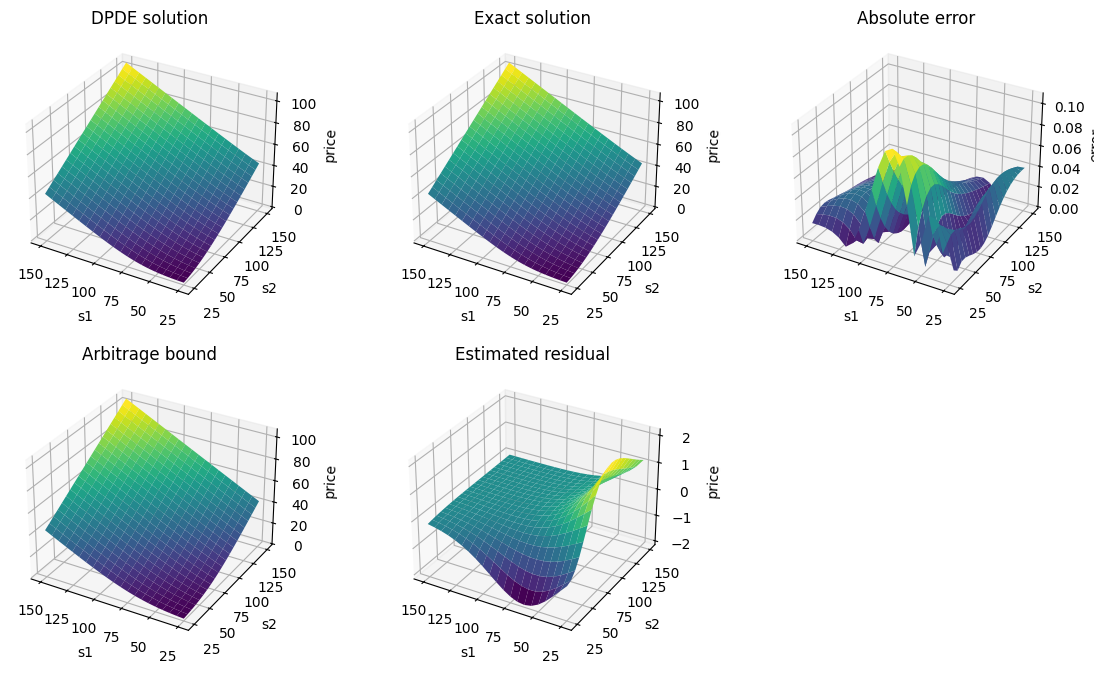

In [13]:
fig, axs = plt.subplots(2, 3, figsize=(14, 8), subplot_kw={'projection': '3d'})

axs[0, 0].plot_surface(s1_plot_mesh, s2_plot_mesh, dpde_sol, cmap='viridis')
axs[0, 0].set_title('DPDE solution')
axs[0, 0].set_xlabel('s1')
axs[0, 0].set_ylabel('s2')
axs[0, 0].set_zlabel('price')
axs[0, 0].set_xlim(axs[0, 0].get_xlim()[::-1])

axs[0, 1].plot_surface(s1_plot_mesh, s2_plot_mesh, exact_sol_eval, cmap='viridis')
axs[0, 1].set_title('Exact solution')
axs[0, 1].set_xlabel('s1')
axs[0, 1].set_ylabel('s2')
axs[0, 1].set_zlabel('price')
axs[0, 1].set_xlim(axs[0, 1].get_xlim()[::-1])

axs[0, 2].plot_surface(s1_plot_mesh, s2_plot_mesh, err, cmap='viridis')
axs[0, 2].set_title('Absolute error')
axs[0, 2].set_xlabel('s1')
axs[0, 2].set_ylabel('s2')
axs[0, 2].set_zlabel('error')
axs[0, 2].set_xlim(axs[0, 2].get_xlim()[::-1])

axs[1, 0].plot_surface(s1_plot_mesh, s2_plot_mesh, bound, cmap='viridis')
axs[1, 0].set_title('Arbitrage bound')
axs[1, 0].set_xlabel('s1')
axs[1, 0].set_ylabel('s2')
axs[1, 0].set_zlabel('price')
axs[1, 0].set_xlim(axs[1, 0].get_xlim()[::-1])


axs[1, 1].plot_surface(s1_plot_mesh, s2_plot_mesh, dpde_sol - bound, cmap='viridis')
axs[1, 1].set_title('Estimated residual')
axs[1, 1].set_xlabel('s1')
axs[1, 1].set_ylabel('s2')
axs[1, 1].set_zlabel('price')
axs[1, 1].set_xlim(axs[1, 1].get_xlim()[::-1])

fig.delaxes(axs[1, 2])

plt.subplots_adjust(hspace=0.2)

plt.show()

Now, let us compute the option price using:
- the PDE solution of the call if we are pricing a put option (and inversely),
- the call-put parity.

We define the opposite option type as a call if we are pricing a put option and inversely.

In [ ]:
# opposite model (one model associated to one option type)
opt_type_opp = 'put' if opt_type=='call' else 'call'

In [ ]:
def create_network(inputs):
    """ Create the information flow of the model """
    layer0 = keras.layers.Dense(nb_neurons, activation="tanh")
    layer1 = HighwayLayer(units=nb_neurons, original_input=dim_tot)
    layer2 = HighwayLayer(units=nb_neurons, original_input=dim_tot)
    layer3 = HighwayLayer(units=nb_neurons, original_input=dim_tot)
    layer4 = keras.layers.Dense(1)

    outputs0 = layer0(inputs)
    outputs1 = layer1({'previous_layer': outputs0, 'original_variable': inputs})
    outputs2 = layer2({'previous_layer': outputs1, 'original_variable': inputs})
    outputs3 = layer3({'previous_layer': outputs2, 'original_variable': inputs})
    outputs  = layer4(outputs3)

    bound           = ArbitrageBound(gamma, K, opt_type_opp)  
    bound_outputs   = bound(inputs)
    res             = bound_outputs + outputs

    return res

In [16]:
inputs_opp  = keras.Input(shape=(dim_tot,))
outputs_opp = create_network(inputs_opp)
model_opp   = DPDEModel(inputs=inputs_opp, outputs=outputs_opp, opt_type=opt_type_opp)
model_opp.compile(optimizer=tf.keras.optimizers.Adam(init_lr))
model_opp.load_weights(f'models/model_{opt_type_opp}.weights.h5')

dpde_sol_opp = model_opp.predict(x_plot_norm).reshape(n_points_surface_plot, n_points_surface_plot)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


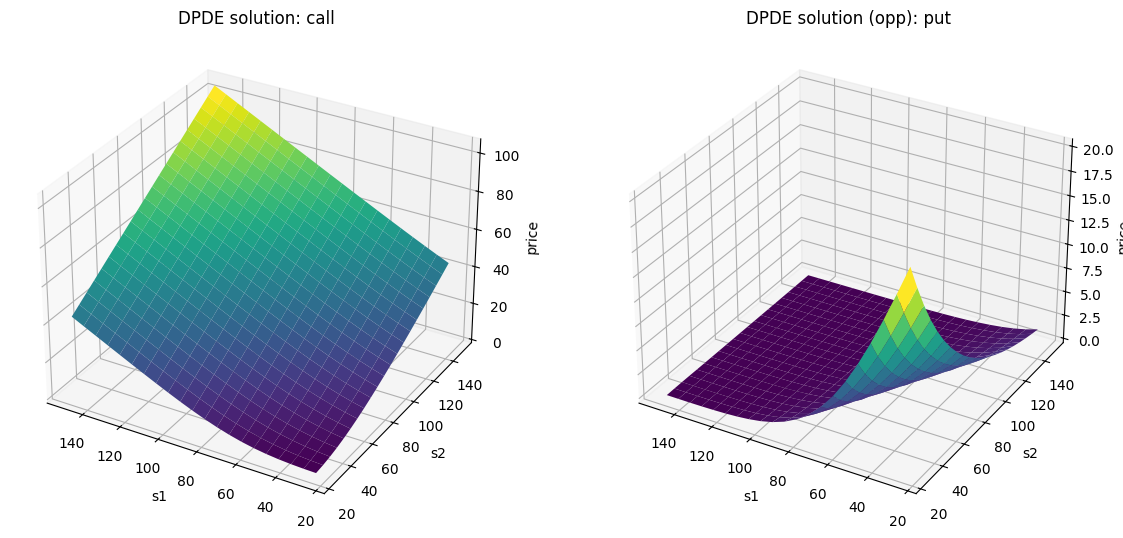

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 8), subplot_kw={'projection': '3d'})

axs[0].plot_surface(s1_plot_mesh, s2_plot_mesh, dpde_sol, cmap='viridis')
axs[0].set_title(f'DPDE solution: {opt_type}')
axs[0].set_xlabel('s1')
axs[0].set_ylabel('s2')
axs[0].set_zlabel('price')
axs[0].set_xlim(axs[0].get_xlim()[::-1])

axs[1].plot_surface(s1_plot_mesh, s2_plot_mesh, dpde_sol_opp, cmap='viridis')
axs[1].set_title(f'DPDE solution (opposite option type): {opt_type_opp}')
axs[1].set_xlabel('s1')
axs[1].set_ylabel('s2')
axs[1].set_zlabel('price')
axs[1].set_xlim(axs[1].get_xlim()[::-1])

plt.show()

The call-put parity is defined as $\text{Call} - \text{Put} = S - Ke^{-rT}$.

In [18]:
parity_gen = lambda rf, K: (
    lambda price, stock1, stock2 : (
        price + K*np.exp(-rf*t_max_dom) - .5*(stock1 + stock2)
        if opt_type == 'put' else price + .5*(stock1 + stock2) - K*np.exp(-rf*t_max_dom)
    )
)

parity = parity_gen(rf_eval, K)

In [19]:
parity_dpde_sol = parity(
    dpde_sol_opp, s1_plot_mesh, s2_plot_mesh
)

Let us compare the results of the option price obtained directly with the DPDE method, and the one obtained with the call-put parity (and the opposite option price predicted with the DPDE method).

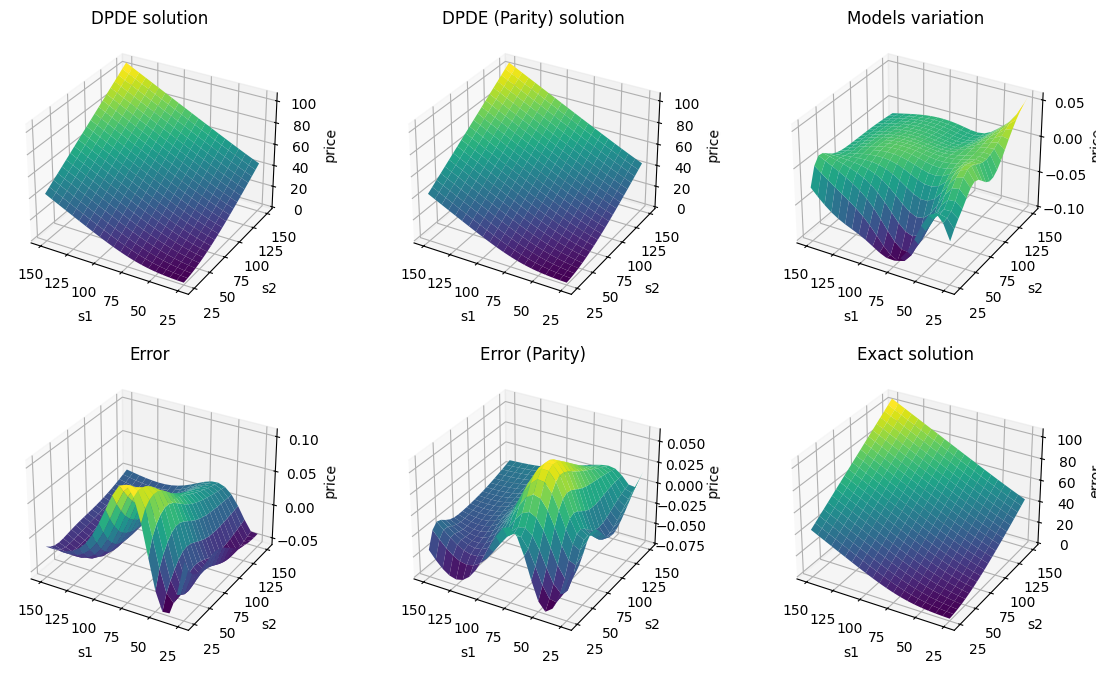

In [20]:
fig, axs = plt.subplots(2, 3, figsize=(14, 8), subplot_kw={'projection': '3d'})

axs[0, 0].plot_surface(s1_plot_mesh, s2_plot_mesh, dpde_sol, cmap='viridis')
axs[0, 0].set_title('DPDE solution')
axs[0, 0].set_xlabel('s1')
axs[0, 0].set_ylabel('s2')
axs[0, 0].set_zlabel('price')
axs[0, 0].set_xlim(axs[0, 0].get_xlim()[::-1])

axs[0, 1].plot_surface(s1_plot_mesh, s2_plot_mesh, parity_dpde_sol, cmap='viridis')
axs[0, 1].set_title('DPDE (Parity) solution')
axs[0, 1].set_xlabel('s1')
axs[0, 1].set_ylabel('s2')
axs[0, 1].set_zlabel('price')
axs[0, 1].set_xlim(axs[0, 1].get_xlim()[::-1])

axs[0, 2].plot_surface(s1_plot_mesh, s2_plot_mesh, parity_dpde_sol - dpde_sol, cmap='viridis')
axs[0, 2].set_title('Models variation')
axs[0, 2].set_xlabel('s1')
axs[0, 2].set_ylabel('s2')
axs[0, 2].set_zlabel('price')
axs[0, 2].set_xlim(axs[0, 2].get_xlim()[::-1])

axs[1, 0].plot_surface(s1_plot_mesh, s2_plot_mesh, dpde_sol - exact_sol_eval, cmap='viridis')
axs[1, 0].set_title('Error')
axs[1, 0].set_xlabel('s1')
axs[1, 0].set_ylabel('s2')
axs[1, 0].set_zlabel('price')
axs[1, 0].set_xlim(axs[1, 0].get_xlim()[::-1])

axs[1, 1].plot_surface(s1_plot_mesh, s2_plot_mesh, parity_dpde_sol - exact_sol_eval, cmap='viridis')
axs[1, 1].set_title('Error (Parity)')
axs[1, 1].set_xlabel('s1')
axs[1, 1].set_ylabel('s2')
axs[1, 1].set_zlabel('price')
axs[1, 1].set_xlim(axs[1, 1].get_xlim()[::-1])

axs[1, 2].plot_surface(s1_plot_mesh, s2_plot_mesh, exact_sol_eval, cmap='viridis')
axs[1, 2].set_title('Exact solution')
axs[1, 2].set_xlabel('s1')
axs[1, 2].set_ylabel('s2')
axs[1, 2].set_zlabel('error')
axs[1, 2].set_xlim(axs[1, 2].get_xlim()[::-1])

plt.subplots_adjust(hspace=0.2)

plt.show()

### <span id="section-2-2" style="color:#00B8DE"> II.2 - Error for randomly sampled points </span>

Then, we display the option prices for randomly sampled points in the parameter space for our Deep Parametric PDE method and the reference pricer (no fixed parameters).

In [21]:
def get_rd_points_dom(n_samples, t_min_dom, t_max_dom, s_min_dom, s_max_dom, param_min_norm, param_max_norm):
    """ Get a number of random points within the defined domain of interest. """
    t_sample            = np.random.uniform(t_min_dom, t_max_dom, [n_samples, 1])
    t_sample_norm       = transform_ab_to_cd(t_sample, t_min_dom, t_max_dom, norm_min, norm_max)

    s_sample        = np.random.uniform(s_min_dom, s_max_dom, [n_samples, dim_state])
    s1_sample       = s_sample[:, 0:1]
    s2_sample       = s_sample[:, 1:2]
    x_sample_norm   = transform_ab_to_cd(np.log(s_sample), x_min, x_max, norm_min, norm_max)

    param_sample_norm = np.random.uniform(param_min_norm, param_max_norm, [n_samples, dim_param])
    
    data_norm = np.concatenate((t_sample_norm, x_sample_norm, param_sample_norm), axis=1)

    rf_sample   = transform_ab_to_cd(param_sample_norm[:, 0], norm_min, norm_max, rf_min, rf_max)
    vol1_sample = transform_ab_to_cd(param_sample_norm[:, 1], norm_min, norm_max, vol_min, vol_max)
    vol2_sample = transform_ab_to_cd(param_sample_norm[:, 2], norm_min, norm_max, vol_min, vol_max)
    corr_sample = transform_ab_to_cd(param_sample_norm[:, 3], norm_min, norm_max, corr_min, corr_max)

    return data_norm, t_sample.reshape(-1), s1_sample.reshape(-1), s2_sample.reshape(-1), rf_sample, vol1_sample, vol2_sample, corr_sample

In [22]:
data_norm_sample, t_sample, s1_sample, s2_sample, rf_sample, vol1_sample, vol2_sample, corr_sample = get_rd_points_dom(n_samples_scatter_plot, t_min_dom, t_max_dom, s_min_dom, s_max_dom, -1, 1)

In [23]:
dpde_sol_1D = None

print('Predict {} values and measure the time:'.format(n_samples_scatter_plot))
%time dpde_sol_1D = model.predict(data_norm_sample)

Predict 1000 values and measure the time:
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
CPU times: total: 266 ms
Wall time: 201 ms


In [24]:
exact_sol_sample    = [exact_solution(t, s1, s2, rf, vol1, vol2, corr, opt_type) for t, s1, s2, rf, vol1, vol2, corr
                        in zip(t_sample, s1_sample, s2_sample, rf_sample, vol1_sample, vol2_sample, corr_sample)]
exact_sol_sample    = np.array(exact_sol_sample).reshape(-1,1)
err                 = np.abs(dpde_sol_1D - exact_sol_sample)   

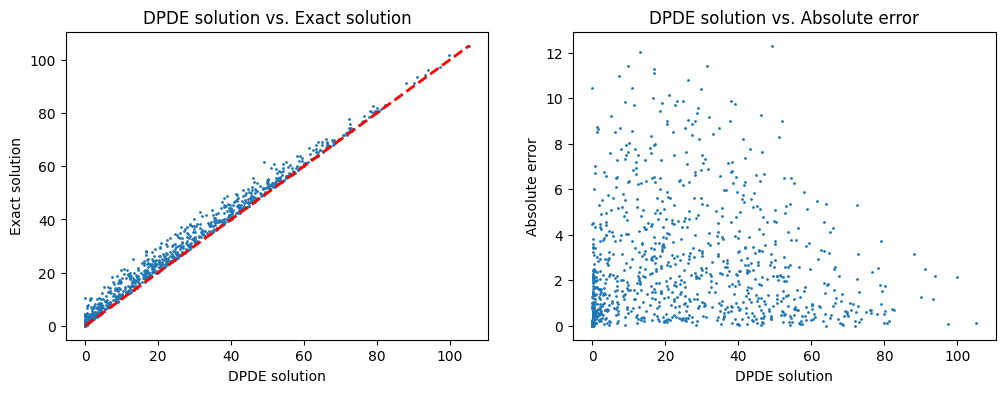

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].scatter(dpde_sol_1D, exact_sol_sample, s=1)
axs[0].set_title('DPDE solution vs. Exact solution')
axs[0].set_xlabel('DPDE solution')
axs[0].set_ylabel('Exact solution')
max_val = max(np.max(dpde_sol_1D), np.max(exact_sol_sample))
axs[0].plot([0, max_val], [0, max_val], 'r--', lw=2)


axs[1].scatter(dpde_sol_1D, err, s=1)
axs[1].set_title('DPDE solution vs. Absolute error')
axs[1].set_xlabel('DPDE solution')
axs[1].set_ylabel('Absolute error')

plt.show()

Finally, let us compute the RMSE of our method.

In [26]:
data_norm_sample, t_sample, s1_sample, s2_sample, rf_sample, vol1_sample, vol2_sample, corr_sample = get_rd_points_dom(n_samples_oos_error, t_min_dom, t_max_dom, s_min_dom, s_max_dom, -1, 1)

In [27]:
print('Predict {} values and measure the time:'.format(n_samples_scatter_plot))
%time dpde_sol_1D = model.predict(data_norm_sample)

Predict 1000 values and measure the time:
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step
CPU times: total: 672 ms
Wall time: 400 ms


In [28]:
exact_sol_sample        = [exact_solution(t, s1, s2, rf, vol1, vol2, corr, opt_type) for t, s1, s2, rf, vol1, vol2, corr
                                in zip(t_sample, s1_sample, s2_sample, rf_sample, vol1_sample, vol2_sample, corr_sample)]
exact_sol_sample        = np.array(exact_sol_sample).reshape(-1,1)
err                     = np.abs(dpde_sol_1D - exact_sol_sample)
rmse                    = np.sqrt(np.mean(np.square(err)))

print(f'estimated RMSE = {rmse:.2f}')
print(f'normalized estimated RMSE = {rmse/np.sqrt(np.mean(np.square(exact_sol_sample))):.2%}')
print(f'Maximal absolute error = {np.max(err):.2f}')

estimated RMSE = 3.49
normalized estimated RMSE = 9.67%
Maximal absolute error = 13.85
